# **Grid Search, Algorithm Chains and Pipelines**


### Machine Learning for Predictive Problems


### October 27




<a href="#/1/1">(Index)</a>


0\. <a href="#/2/1">Cross-Validation</a>

1\. <a href="#/7/1">Grid Search</a>:
   * Simple.
   * <a href="#/15/1">With cross-validation</a>.
   
2\. <a href="#/25/1">Algorithm Chains and Pipelines</a>
   * <a href="#/28/1">Parameter Selection with Preprocessing</a>.
   * <a href="#/31/1">The *Pipeline* Class</a>.
   * <a href="#/33/1">An example of Information Leakage</a>.
   * <a href="#/35/1">The General Pipeline Interface</a>
   
3\. <a href="#/42/1">Conclusions</a>

# Cross-Validation
Cross-validation is primarily a way of measuring the predictive performance of a statistical model. 

<a href="#/1/1">(Index)</a>

### K-Fold cross-validation
<center><img src="./images/04-K-fold_cv.png" style="width: 750px;"/></center>
* Avoid *random* bias during selection of train and test data.
* How sensitive is our model to the selection of the training set.
* Computational cost is *k*.

### Stratified k-fold cross validation
<center><img src="./images/04-SK-fold_cv.png" alt="Drawing" style="width: 750px;"/></center>
* Keeps the proportion between classes in each fold as they are in the whole dataset.
* Good strategy with Imbalanced datasets (but use other strategies if proportion is more than 9 to 1).

### Leave-one-out cross-validation
<center><img src="./images/04-LOO_cv.png" alt="Drawing" style="width: 750px;"/></center>
* Good results in small datasets.
* Time consuming for large datasets.

### Shuffle-split cross-validation
<center><img src="./images/04-Random_cv.png" alt="Drawing" style="width: 750px;"/></center>
* Good strategy with large datasets.

# Grid Search

Improve the models' generalization performance by tuning its parameters.


<a href="#/1/1">(Index)</a>

## Simple Grid Search

Using *for* loops over the parameters of a model.

In [1]:
# naive grid search implementation
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Size of training set: {} size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

Size of training set: 112 size of test set: 38


In [2]:
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Best score: 0.97
Best parameters: {'gamma': 0.001, 'C': 100}


## Overfiting *parameters* and the Validation Set

* We have tried different parameters and select the best ones on the *test set*.
* Test data should not be use to assess how good is the model.
* A new independent data set is necessary $\to$ Validation set.

<center><img src="./images/04-TVT_sets.png" alt="Drawing" style="width:1000px" align="middle"/></center>
* **Training set**: build the model.
* **Validation set**: select the parameters of the model.
* **Test set**: evaluate the performance of the selected parameters.

After selecting the best parameters using the validation set, we can rebuild a model using the parameter settings we found, but now training on both the training data and the validation data.

In [3]:
from sklearn.svm import SVC

# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print("Size of training set: {} size of validation set: {} size of test set:" 
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Size of training set: 84 size of validation set: 28 size of test set: 38



In [4]:
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

In [5]:
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.96
Best parameters:  {'gamma': 0.001, 'C': 10}
Test set score with best parameters: 0.92


## Grid Search with Cross-Validation

* For a better estimate of the generalization performance. 

* Instead of using a single split into a training and a validation set, we can use cross-validation to evaluate the performance of each parameter combination.

In [6]:
import numpy as np
from sklearn.model_selection import cross_val_score

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.97
Best parameters:  {'gamma': 0.01, 'C': 100}
Test set score with best parameters: 0.97


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}\n".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.97
Best parameters: {'gamma': 0.01, 'C': 100}
Best cross-validation score: 0.97

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


**best$\underline{}$score$\underline{}$** $\to$ The  mean accuracy over the different splits for the parameters setting. On the training set.


### Analyzing the results (cv$\underline{}$results$\underline{}$)

We can inspect the results of the cross-validated grid search.

In [8]:
import pandas as pd
from IPython.display import display
# convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# show the first 5 rows
display(results.head())

mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.001291         0.000479         0.366071          0.366079   0.001   
1       0.001045         0.000392         0.366071          0.366079   0.001   
2       0.001342         0.000574         0.366071          0.366079   0.001   
3       0.001153         0.000424         0.366071          0.366079   0.001   
4       0.001379         0.000664         0.366071          0.366079   0.001   

  param_gamma                        params  rank_test_score  \
0       0.001  {'gamma': 0.001, 'C': 0.001}               22   
1        0.01   {'gamma': 0.01, 'C': 0.001}               22   
2         0.1    {'gamma': 0.1, 'C': 0.001}               22   
3           1      {'gamma': 1, 'C': 0.001}               22   
4          10     {'gamma': 10, 'C': 0.001}               22   

   split0_test_score  split0_train_score       ...         split2_test_score  \
0              0.375            0.363636       ...                  0.363636   
1              0.375            0.363636       ...                  0.363636   
2              0.375            0.363636       ...                  0.363636   
3              0.375            0.363636       ...                  0.363636   
4              0.375            0.363636       ...                  0.363636   

   split2_train_score  split3_test_score  split3_train_score  \
0            0.366667           0.363636            0.366667   
1            0.366667           0.363636            0.366667   
2            0.366667           0.363636            0.366667   
3            0.366667           0.363636            0.366667   
4            0.366667           0.363636            0.366667   

   split4_test_score  split4_train_score  std_fit_time  std_score_time  \
0           0.380952            0.362637      0.000176        0.000055   
1           0.380952            0.362637      0.000044        0.000029   
2           0.380952            0.362637      0.000398        0.000114   
3           0.380952            0.362637      0.000101        0.000029   
4           0.380952            0.362637      0.000378        0.000299   

   std_test_score  std_train_score  
0        0.011371         0.002852  
1        0.011371         0.002852  
2        0.011371         0.002852  
3        0.011371         0.002852  
4        0.011371         0.002852  

[5 rows x 22 columns]

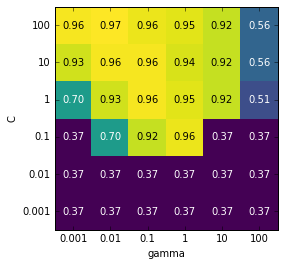

In [9]:
%matplotlib inline
import mglearn
import matplotlib.pyplot as plt

scores = np.array(results.mean_test_score).reshape(6, 6)
# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

In [10]:
param_grid_linear = {'C': np.linspace(1, 2, 6),
                     'gamma': np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
                      'gamma': np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
                    'gamma': np.logspace(-7, -2, 6)}

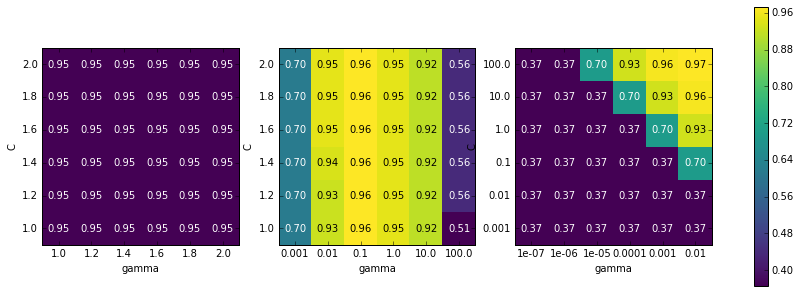

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # plot the mean cross-validation scores
    scores_image = mglearn.tools.heatmap(
                   scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
                   yticklabels=param_grid['C'], cmap="viridis", ax=ax)
plt.colorbar(scores_image, ax=axes.tolist())

### Search over spaces (not grids)

* In general is not a good idea.
* But, in some cases is possible to try *all possible* combinations of *all paramenters*.
* Pass to GridSearch a **list of dictionaries**. Each dictionary an independent grid.

In [12]:
# We test the SVC classifier with two type of kernels.
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'gamma': 0.01, 'kernel': 'rbf', 'C': 100}
Best cross-validation score: 0.97


In [13]:
results = pd.DataFrame(grid_search.cv_results_)
# we display the transposed table so that it better fits on the page:
display(results.T)

0   \
mean_fit_time                                          0.00114141   
mean_score_time                                       0.000410795   
mean_test_score                                          0.366071   
mean_train_score                                         0.366079   
param_C                                                     0.001   
param_gamma                                                 0.001   
param_kernel                                                  rbf   
params              {'gamma': 0.001, 'kernel': 'rbf', 'C': 0.001}   
rank_test_score                                                27   
split0_test_score                                           0.375   
split0_train_score                                       0.363636   
split1_test_score                                        0.347826   
split1_train_score                                       0.370787   
split2_test_score                                        0.363636   
split2_train_score                                       0.366667   
split3_test_score                                        0.363636   
split3_train_score                                       0.366667   
split4_test_score                                        0.380952   
split4_train_score                                       0.362637   
std_fit_time                                          8.42781e-05   
std_score_time                                         3.8798e-05   
std_test_score                                          0.0113708   
std_train_score                                        0.00285176   

                                                              1   \
mean_fit_time                                         0.00106359   
mean_score_time                                      0.000412178   
mean_test_score                                         0.366071   
mean_train_score                                        0.366079   
param_C                                                    0.001   
param_gamma                                                 0.01   
param_kernel                                                 rbf   
params              {'gamma': 0.01, 'kernel': 'rbf', 'C': 0.001}   
rank_test_score                                               27   
split0_test_score                                          0.375   
split0_train_score                                      0.363636   
split1_test_score                                       0.347826   
split1_train_score                                      0.370787   
split2_test_score                                       0.363636   
split2_train_score                                      0.366667   
split3_test_score                                       0.363636   
split3_train_score                                      0.366667   
split4_test_score                                       0.380952   
split4_train_score                                      0.362637   
std_fit_time                                          3.3213e-05   
std_score_time                                       4.74664e-05   
std_test_score                                         0.0113708   
std_train_score                                       0.00285176   

                                                             2   \
mean_fit_time                                        0.00126791   
mean_score_time                                     0.000626564   
mean_test_score                                        0.366071   
mean_train_score                                       0.366079   
param_C                                                   0.001   
param_gamma                                                 0.1   
param_kernel                                                rbf   
params              {'gamma': 0.1, 'kernel': 'rbf', 'C': 0.001}   
rank_test_score                                              27   
split0_test_score                                         0.375   
split0_train_score                  

## Extra info


* You can Parallelize the cross-validation and grid search by passing the option `n_jobs=-1`

* GridSearchCV uses stratified *k*-fold cross-validation by default. But you can change it by passing a different
instruction to the **cv** variable. eg. 

    ```from sklearn.model_selection import LeaveOneOut
  loo = LeaveOneOut()
  grid_search = GridSearchCV(SVC(), param_grid, cv=loo)```



# Algorithm Chains and Pipelines

<a href="#/1/1">(Index)</a>

## Pipeline and GridSearchCV Classes

A machine learning problem usually includes:

* Scaling the data and combining features by hand. Learning features using unsupervised machine learning.

* Chaining together many different processing steps and machine learning models.

In [14]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer() 
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)
svm = SVC()

# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)

# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


## Parameter Selection with Preprocessing

* Find the best parameters for *SVC* using *GridSearch* $\to$ Just add the grid parameters.


In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'gamma': 1, 'C': 1}


# ERROR $\Rightarrow$ The grid search is done using the scaled data!
* But the scaled data was done on the whole data in the training set.
* For each split in the cross-validation some information is leaked from the test set into the training set.

<center><img src="./images/04-pipelines.png" alt="Drawing" style="width:1500px" align="middle"/></center>




# The *Pipeline* Class

You can create a *workflow* for training and classification after preprocessing.

In [16]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))


Test score: 0.95


## Pipelines in Grid Searches
Pipelines and grid search are combined in the same way that any estimator.


In [17]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
               'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__gamma': 1, 'svm__C': 1}


# Information Leakage

Example adapted from *The Elements of Statistical Learning*.

In [18]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [19]:
from sklearn.feature_selection import SelectPercentile, f_regression
select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
    np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


$R^2$ computed by cross-validation is 0.91 $\to$ a very good model. **ERROR**

## Proper model with cross-validation using a pipeline

In [21]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, 
                                             percentile=5)),
               ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


a negative $R^2$ score, indicating a very poor model.

## Pipeline Creation with make_pipeline

In [22]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


In general, the step names are just lowercase versions of the class names.

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


**Note:** In this case it might be better to use the Pipeline construction with explicit name.

## Grid-Searching Preprocessing Steps and Model Parameters

In [24]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,random_state=0)

pipe = make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())

In [25]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'polynomialfeatures__degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

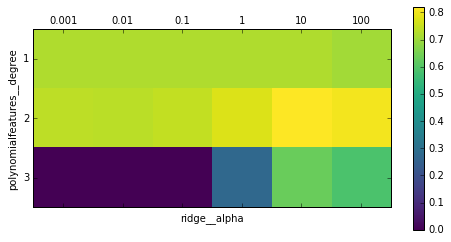

In [26]:
plt.figure(figsize=(12,8))
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
param_grid['polynomialfeatures__degree'])
plt.colorbar()

In [27]:
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'ridge__alpha': 10, 'polynomialfeatures__degree': 2}
Test-set score: 0.77


## Exhaustive Grid Search
* Again, it is not a recomendable strategy.
* If your dataset is large you can try on a random subset.

In [28]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)}

Best cross-validation score: 0.99
Test-set score: 0.98


## Randomized Parameter Optimization

`RandomizedSearchCV` implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values.

Advantages:
* A budget can be chosen independent of the number of parameters and possible values.
* Adding parameters that do not influence the performance does not decrease efficiency.

See: Bergstra, J. and Bengio, Y., Random search for hyper-parameter optimization, The Journal of Machine Learning Research (2012).

# Conclusions
* Split into training data for model building, validation data for model and parameter selection, and test data for model evaluation.
* The Pipeline class is a general-purpose tool to chain together multiple processing steps in a machine learning workflow.
* Choosing the right combination of feature extraction, preprocessing, and models is somewhat of an art, and often requires some trial and error.

## Tips for parameter search

* **Specifying an objective metric**. For some applications, other scoring functions are better suited
* **Specifying multiple metrics for evaluation**. `GridSearchCV` and `RandomizedSearchCV` allow specifying multiple metrics for the scoring parameter.
* **Composite estimators and parameter spaces**. Use pipelines and caching transformers to avoid repeated computation. See `sklearn` manual.
* **Model selection: development and evaluation**. This can be done by using `the train_test_split` utility function.
* **Parallelism**.
* **Robustness to failure**. Setting `error_score=0` (or `=np.NaN`) will make the procedure robust to such failure.

## Alternatives to brute force parameter search

* **Model specific cross-validation**. Some models can fit data for a range of values of some parameter almost as efficiently as fitting the estimator for a single value of the parameter. This feature can be leveraged to perform a more efficient cross-validation used for model selection of this parameter. eg. `linear_model.RidgeCV`,
`linear_model.RidgeClassifierCV `, `linear_model.LogisticRegressionCV`.
* ** Information Criterion**. Some models can offer an information-theoretic closed-form formula of the optimal estimate of the regularization parameter by computing a single regularization path (instead of several when using cross-validation). eg. `linear_model.LassoLarsIC`
* **Out of Bag Estimates**. When using ensemble methods base upon bagging, i.e. generating new training sets using sampling with replacement, part of the training set remains unused. For each classifier in the ensemble, a different part of the training set is left out. eg. `ensemble.RandomForestClassifier`, `ensemble.GradientBoostingClassifier`




# Homework 4

* On the 20 Newsgroups data set use two classifiers and optimize their parameters using grid-search and pipelines. Report accuracy and computational time. 